In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras as k

Using TensorFlow backend.


# Train a Convolutional Neural Network to Classify MNIST

*J. Radford (j.radford.1@research.gla.ac.uk)* <br>

Extreme Light group - Univ. of Glasgow <br>
_(http://www.physics.gla.ac.uk/XtremeLight/index.html)_

**Why not just rearrange our image as a big long vector and use a normal neural network?**
Usually features in an image are spread over neigbouring pixels, if we scan a 2D image with a small grid instead (kernel) then we'll capture those clustered features which might be missed when reshaping the image into a long vector. Another benefis of this is that instead of the huge computational burden of connecting every pixel to every node in the first layer, we only use the pixels whilst the small kernel scans over them so it reduces the number of calculations too.

## *Contents:*
1. Load data
2. Define model
3. Train model
4. Evaluate who well it performs
5. Use the model on our own data
6. Taking control of kernels

## 1. Load data

In [2]:
(x_train, y_train), (x_test, y_test) = k.datasets.mnist.load_data()

Let's look at what we just loaded:

In [3]:
print('x_train: {}'.format(x_train.shape),
      'y_train: {}'.format(y_train.shape),
      'x_test: {}'.format(x_test.shape),
      'y_test: {}'.format(y_test.shape)
     )

x_train: (60000, 28, 28) y_train: (60000,) x_test: (10000, 28, 28) y_test: (10000,)


``x_train`` - We have 60,000 (28x28) images of handwritten digits to train the classifier.

``y_train`` - There are 60,000 corresponding labels which tell us which number is represented in the image.

``x_test`` - These 10,000 images are not used for training. We'll keep these to test how good our model is at predicting the number in some **unseen** images.

``y_test`` - Corresponding labels for the x_test images. We'll use these as a ground truth to check how many of the test images our model guessed correctly.

Lets have a look at the first 25 images in the training set, we'll use the ``y_train`` labels as titles to the images:

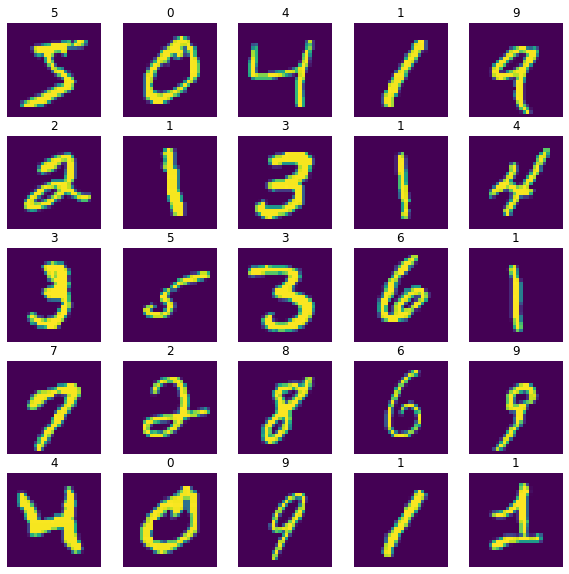

In [4]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(x_train[i,:,:])
    plt.title('{}'.format(y_train[i]))
    plt.axis('off')

# 2. Define a model

First we need to use tensorflow to make a network, we'll call it ``model``:

In [5]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = k.Sequential([
    Conv2D(20, (3,3), padding='same', activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2), strides=2),
    Conv2D(40, (3,3), padding='same', activation='relu'),
    MaxPooling2D((2, 2), strides=2),
    Flatten(),    
    Dense(80, activation='relu'),
    Dense(10,  activation='softmax')
])


### Let's break it down:

Model specs:
- ``Sequential`` So that each layer will pass into the next layer 
- ``Conv2D`` The 1st layer is has ``20`` ``(3,3)`` convolutional filters (sometimes referred to as kernels) which will each scan over our image like this: <img src="https://miro.medium.com/max/790/1*1okwhewf5KCtIPaFib4XaA.gif" width="200" align="center"> 
<center><em>The image (blue), is scanned with a (3x3) filter (grey) and the output <br>of each of the filters will produce 20 feature maps of the image (green).</em></center>
<br>
<br>
- ``padding`` Notice that there needs to be padding added around our image for the scan to work at the edges. Using the ``same`` argument will make sure that our feature maps are the same size as our input image to the layer.
- ``activation`` All our 20 feature maps have 28x28 pixels. Each feature map has a weight which will multiply all the pixels by the same number, this is a learned weight because some maps will more important for the task than others. Then all the feature maps are summed pixel-wise and each pixel will act as a node with an activation function. In most cases we use the simple but very effective non-linear *rectified linear unit* or ``relu`` function (below).

<img src="https://miro.medium.com/max/2052/1*DfMRHwxY1gyyDmrIAd-gjQ.png" width="400">

- ``input_shape`` This will be the dimensions of our image. Notice we added an extra dimension on the end, this is because the model will eventually store all the feature maps in this dimension so we'll need to add a dimension to our training and test input data. Luckily there's an easy way to do that: 

In [6]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

print('x_train: {}'.format(x_train.shape))
print('x_test : {}'.format(x_test.shape))

x_train: (60000, 28, 28, 1)
x_test : (10000, 28, 28, 1)


- ``MaxPooling`` - The 2nd layer in our model is a dimensionality reduction. This scans a filter with shape ``(2,2)``over the output from the ``Conv2D`` layer and simply takes the maximum value of every step to be the downsampled pixel value. The ``strides`` argument just tells the filter how many pixels to step along during the scan. <img src="https://www.oreilly.com/radar/wp-content/uploads/sites/3/2019/06/Figure_4-87c227113cdd0b73d842267404d4aa00.gif" width="400"> <center><em>Max-pooling by scanning a 2x2 filter in strides of 2 pixels to <br>downsample the output of the previous layer</em></center>

- The next layer doubles the number of filters and feature maps to ``40`` and downsamples the image size again with another ``MaxPooling`` layer. Usually the first layer will capture basic features such as edges and fundamental shapes in the input, as we progress through the layers, there are a lot more features we're looking for which are more complex and intricate, this is why the number of filters is increased.

- ``Flatten`` The 5th layer in the model will take the output of layer 4 and arrange it as a long 1D vector so we can use a fully connected neural network to do the classification task.
- ``Dense`` The penultimate layer will use 80 fully connected neurons and the output of the convolutional feature extraction and learn which features correspond to the labels.
- ``softmax`` Notice that we're using a different activation function in the final layer, this will normalise all the outputs to sum=1 so we get a **probability** of being each class instead of looking for the largest number.
- You should also take note that we only have 10 nodes in the last layer, we can't really change this because there are only 10 different options in our labels:

labels --> [0,9]


<BarContainer object of 10 artists>

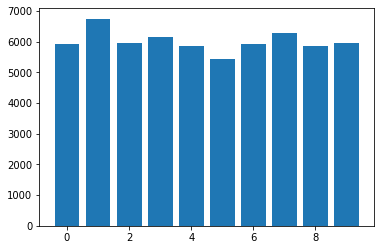

In [7]:
print('labels --> [{},{}]'.format(y_train.min(), y_train.max()))

# plot the labels as a histogram to visualise 10 different possibilities
hist = np.histogram(y_train, bins=np.arange(11))
plt.bar(hist[1][:-1], hist[0])

### Get tensorflow to summarise what we've built (great for trouble shooting errors!):

In [8]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 20)        200       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 20)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 40)        7240      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 40)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1960)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 80)                156880    
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

# 3. Train the model

### First we need to compile the model and choose the hyper-parameters

In [9]:
model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']
             )
print('Compiled! Ready to start training..')

Compiled! Ready to start training..


 - ``optimizer`` We're using gradient descent so the step we take in the gradient direction on each iteration needs to be determined. In this case we're using a technique developed in http://arxiv.org/abs/1412.6980 to efficiently solve the problem. There are lots of optimizers to try:
     - Adadelta
     - Adagrad
     - Adam
     - Adamax
     - Nadam
     - RMSprop
     - SGD
     
 - ``loss`` This is the objective function we're minimising. using ``sparse_categorical_crossentropy`` will compare the probability outcome of our model with the real result to minimise the difference in pobability distribution. The sparse part is just because our ``y_train`` and ``y_test`` data is integers rather than how the output nodes are arranged as a string of ones and zeros.
 
 - ``metrics`` We want to monitor how well the model is doing and ``['accuracy']`` will report the percentage of correct predictions as an output when we're training and testing.

### Train the model with the training data

In [10]:
model.fit(x_train, y_train,
          epochs=10,
          batch_size=30,
          shuffle='True'
         )

# use model.save() and model.load() to save the 
# trained model and use it in future
model.save('example_CNN')

Epoch 1/10
60000/60000 [==============================] - 8s 132us/step - loss: 0.2638 - accuracy: 0.9489
Epoch 2/10
60000/60000 [==============================] - 6s 104us/step - loss: 0.0593 - accuracy: 0.9824
Epoch 3/10
60000/60000 [==============================] - 6s 104us/step - loss: 0.0476 - accuracy: 0.9850
Epoch 4/10
60000/60000 [==============================] - 6s 104us/step - loss: 0.0386 - accuracy: 0.9883
Epoch 5/10
60000/60000 [==============================] - 6s 106us/step - loss: 0.0330 - accuracy: 0.9897
Epoch 6/10
60000/60000 [==============================] - 7s 111us/step - loss: 0.0287 - accuracy: 0.9910
Epoch 7/10
60000/60000 [==============================] - 7s 109us/step - loss: 0.0259 - accuracy: 0.9924
Epoch 8/10
60000/60000 [==============================] - 6s 106us/step - loss: 0.0218 - accuracy: 0.9931
Epoch 9/10
60000/60000 [==============================] - 6s 104us/step - loss: 0.0223 - accuracy: 0.9934
Epoch 10/10
60000/60000 [=====================

- ``epochs`` The number of times the entire training data is passed throught the model
- ``batch_size`` Calculating the gradient for the entire 60,000 training images and labels at once is computationally expensive, so we break it up into chunks of 30 instead. Calculating the gradient 2,000 times on chunks of 30 is much quicker and we can optimise the computer hardware to accelerate the training.
- ``shuffle`` The training set is already shuffled in our case so that we don't introduce the images in order as we train. However, the shuffle parameter will re-shuffle the order of the training data on every epoch so that we'll train with different mini-batches every iteration.

# 4. Evaluate the model
Now we test the performance on our unseen test data:

In [11]:
# model = k.models.load_model('example_CNN', custom_objects={'softmax_v2': tf.nn.softmax})

results = model.evaluate(x_test, y_test)

print('loss: {:.3f}, acc: {:.3f}'.format(results[0],results[1]))

10000/10000 [==============================] - 1s 67us/step
loss: 0.053, acc: 0.989


- ``evaluate`` Takes all our 10,000 test images and compares the prediction with the ground truth. Our model got 98.% of the test images correct.

Now lets **use** the model!

Our model guessed: 3


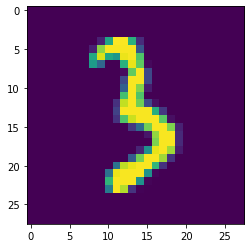

In [12]:
example_image = 44

predict = model.predict(x_test[example_image:example_image+1])

plt.imshow(x_test[example_image,:,:,0])
print('Our model guessed: {}'.format(np.argmax(predict)))

Try changing the ``test_image`` variable above to be a number between 0 and 100. 

In the example above, we're taking the most likely result using the ``np.argmax()`` function but because we trained using ``softmax`` in the output then we can also see the probability of being another class:

 Here is the full prediction probability for all classes: 
[[7.9271685e-16 8.0518903e-10 3.0678693e-02 9.6932125e-01 6.3171615e-20
  3.9627950e-13 1.7704439e-13 1.1068391e-15 7.1585050e-11 5.2291728e-17]]


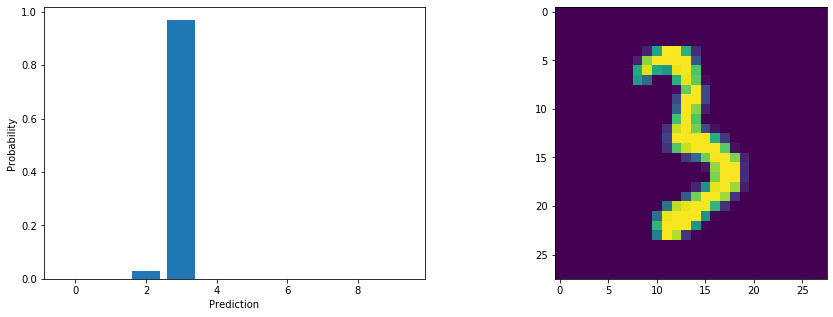

In [13]:
# note: Using \033[1m just makes the text bold
print('\033[1m Here is the full prediction probability\
 for all classes:\033[0m \n{}'.format(predict))

def plot_results(img, prediction):
    # Make a subplot showing full prediction
    # alongside the example image
    
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.bar(np.arange(10), prediction)
    plt.xlabel('Prediction')
    plt.ylabel('Probability')

    plt.subplot(1,2,2)
    plt.imshow(img)

img = x_test[example_image,:,:,0]
prediction = predict[0]

plot_results(img, prediction)

# 5. Using our own data

Let's make our own image and see how well the model predicts the value!

Visit: https://jspaint.app/
Follow these instructions:
- Hit **"fill"** and click anywhere on the blank image to make it black
- Go to the toolbar at the top and click: **"Image" -> "Attributes"**
- Set size to be **28x28 pixel units** and select **black & white** colours with **opaque** transparency
- Hit **"okay"**
- Back to the toolbar and select: **"View" -> "Zoom" -> "Zoom to Window"
- Now select the **Paintbrush** and select the **color white** at the bottom of the screen
- Use the left panel to change the brush **size** to be the **smallest**
- Draw a number between 0 and 9
- **File -> Save** should download the image

<!-- <iframe src="https://giphy.com/embed/hsVJnBeR6wpMkiB313" width="480" height="270" frameBorder="0" class="giphy-embed" allowFullScreen></iframe><p><a href="https://giphy.com/gifs/hsVJnBeR6wpMkiB313">via GIPHY</a></p> -->

<img src="https://github.com/slack-a-jack/ml-getting-started/blob/master/Make%20mnist.gif?raw=true" width="800" align="center">



 ### Now upload it using cv2:

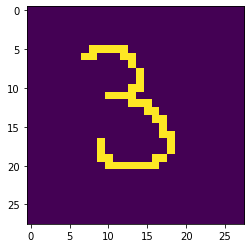

In [14]:
import cv2

# You'll need to use your own file path for your computer!
# It will be pretty close to what I've written below
filename='C:/Users/jack/Downloads/untitled (1).png'

my_img = cv2.imread(filename, 0)

plt.imshow(my_img)

 If it worked, you should see your image!
 
 If you get a **"module not found"** error here then you need to go to anaconda prompt, activate your environment and type ``conda install opencv``. See the first tutorial on getting stuff downloaded for more info on how to do this)
 
 Now we'll use the predict function to see what our classifier thinks it is:

[3.6846970e-29 4.2067802e-25 3.9017891e-22 1.0000000e+00 0.0000000e+00
 3.3030861e-10 2.8254999e-29 2.4350098e-28 1.9040848e-29 1.6380539e-27]


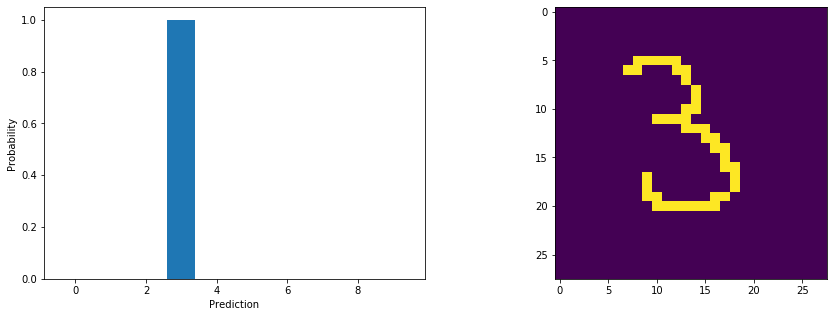

In [15]:
# Remember we need to have all the correct dimensions
my_img_reshaped = np.zeros((1, 28, 28, 1))
my_img_reshaped[0,:,:,0] = my_img

# the predict function is an array of an array 
# so that multiple predctions can be made at once.
# We only have one prediction here so I've taken the
# zeroth element by adding the [0] at the end.
predict_my_img = model.predict(my_img_reshaped)[0]

plot_results(my_img, predict_my_img)
print(predict_my_img)

### Try draw an image which looks difficult and try and fool the classifier

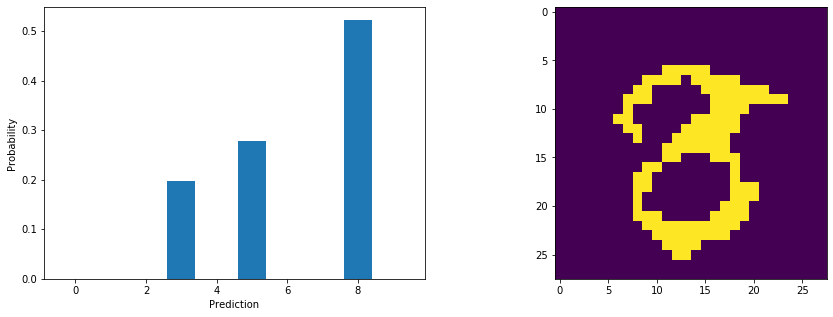

In [16]:
# You'll need to use your own file path for your computer!
# It will be pretty close to what I've written below
filename='C:/Users/jack/Downloads/untitled (10).png'
my_img = cv2.imread(filename, 0)

# Remember we need to have all the correct dimensions
my_img_reshaped = np.zeros((1, 28, 28, 1))
my_img_reshaped[0,:,:,0] = my_img

# the predict function is an array of an array 
# so that multiple predctions can be made at once.
# We only have one prediction here so I've taken the
# zeroth element by adding the [0] at the end.
predict_my_img = model.predict(my_img_reshaped)[0]

plot_results(my_img, predict_my_img)


The classifier is more sure that this is the image of an **8** but it assigns some probability to a **3** and **5**. Just **one pixel** can make a huge difference because of the kernels that we've trained in the model.

# 6. Taking control of kernels (additional material)

A convolutional neural network performs convolutions on images using kernels. We can Explicitly define the kernel and plot the resulting feature maps. This is important to:
- See what features of the image our network has learned to find
- Help speed up the learning process by initialising the learning with a kernel we'd expect to use

Here's how to plot the feature maps of the first layer in our CNN classifier we made:

In [17]:
# How many layers do we have?
print('There are {} layers'.format(len(model.layers)))

# Get name of first layer in model
print('First layer:', model.layers[0].name)

# Lets unpack the first layer
filters, bias = model.layers[0].get_weights()
print('shape:', filters.shape)

There are 7 layers
First layer: conv2d_1
shape: (3, 3, 1, 20)


The shape of the first layer:
- First 2 numbers tell us the kernel size is 3x3
- Third number shows we have 1 channel (e.g. if we had RGB images then this would be 3)
- Last number is the number of kernels we specfied for the first layer to learn (20)

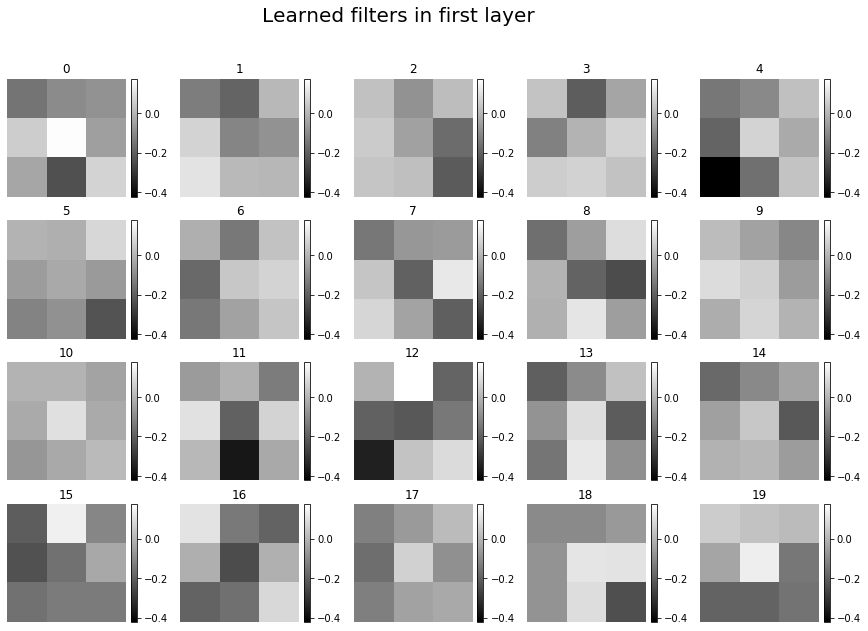

In [18]:
# Now plot all 20 learned filters in the first layer

plt.figure(figsize=(15,10))
for i in range(filters.shape[3]):
    plt.subplot(4, 5, i+1)
    plt.imshow(filters[:,:,0,i], 
               vmax=filters.max(), 
               vmin=filters.min(),
               cmap='gray'
              )
    plt.axis('off')
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.title(i)
plt.suptitle('Learned filters in first layer', size=20);

Filters alone are hard to interpret. An easier way to visualisse what's going on is to plot the feature map of a given test image.

Create a new model which will output the first layer of our learned filters:

In [51]:
# use keras.Model to take the already defined specs from parts of our CNN we trained
# and make a new model which only passes inputs through the first layer
output_layer1 = k.Model(inputs=model.inputs, outputs=model.layers[0].output, name='output_layer1')
output_layer1.summary()

Model: "output_layer1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1_input (InputLayer)  (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 20)        200       
Total params: 200
Trainable params: 200
Non-trainable params: 0
_________________________________________________________________


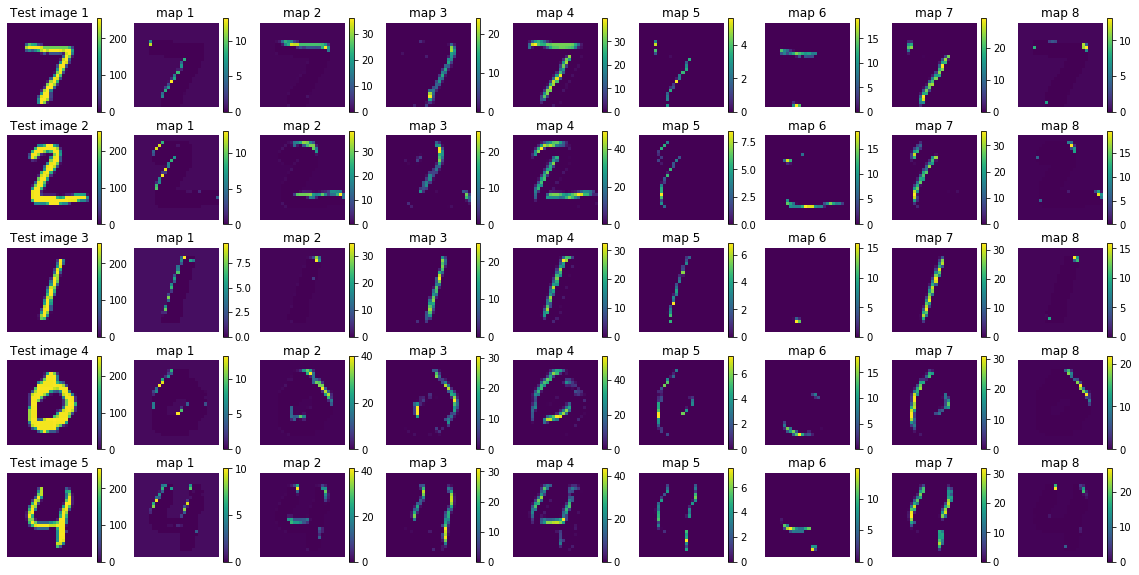

In [52]:
# get the output of the first layer for the first 5 test images
predict = output_layer1.predict(x_test[0:5])

# Make a subplot to show results
fig, ax = plt.subplots(5,9, figsize=(20,10))

for i in range(5):
    for j in range(9):
        if j==0:
            img = ax[i,j].imshow(x_test[i,:,:,0])
            fig.colorbar(img, ax=ax[i,j])
            ax[i,j].set_title('Test image {}'.format(i+1))
            ax[i,j].axis('off')
        else:
            img = ax[i,j].imshow(predict[i,:,:,j-1])
            fig.colorbar(img, ax=ax[i,j])
            ax[i,j].set_title('map {}'.format(j))
            ax[i,j].axis('off')


These are the first 8 feature maps of our learned model, by eye we can make a guess at what it's learning:
- 1st kernel: rotated clock-wise left vertical edges
- 2nd kernel: rotated clock-wise top horizontal edges
- 3rd kernel: right vertical edges
- 4th kernel: all top edges 
- 5th kernel: left vertical edges
- 6th kernel: bottom horizontal edges
- 7th kernel: left vertical edges (same as kernel 5)
- 8th kernel: mainly top right corners

It's even easier to see when saturating the upper values above 10%:

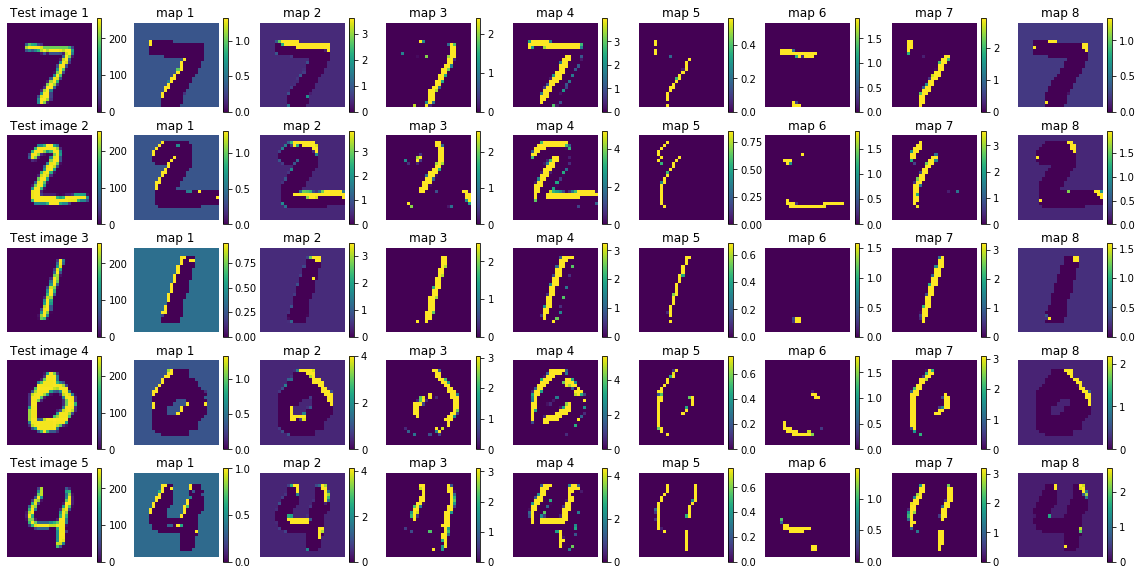

In [53]:
# get the output of the first layer for the first 5 test images
predict = output_layer1.predict(x_test[0:5])

# Make a subplot to show results
fig, ax = plt.subplots(5,9, figsize=(20,10))

for i in range(5):
    for j in range(9):
        if j==0:
            img = ax[i,j].imshow(x_test[i,:,:,0])
            fig.colorbar(img, ax=ax[i,j])
            ax[i,j].set_title('Test image {}'.format(i+1))
            ax[i,j].axis('off')
        else:
            img = ax[i,j].imshow(predict[i,:,:,j-1],
                                vmax=0.1*predict[i,:,:,j-1].max())
            fig.colorbar(img, ax=ax[i,j])
            ax[i,j].set_title('map {}'.format(j))
            ax[i,j].axis('off')


Here is a dictionary of some common kernels for image processing (https://en.wikipedia.org/wiki/Kernel_(image_processing)):

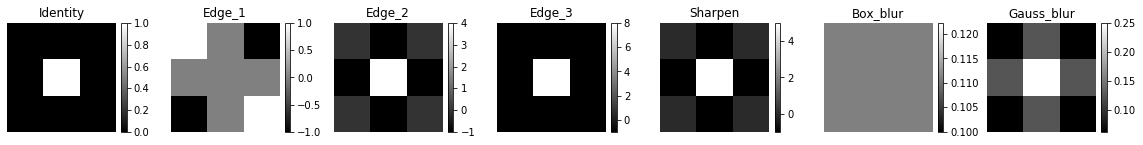

In [22]:
# define some common image processing kernels
Identity = np.array([[0,0,0],
                    [0,1,0],
                    [0,0,0]])

Edge_1 = np.array([[1,0,-1],
                  [0,0,0],
                  [-1,0,1]])

Edge_2 = np.array([[0,-1,0],
                  [-1,4,-1],
                  [0,-1,0]])

Edge_3 = np.array([[-1,-1,-1],
                  [-1,8,-1],
                  [-1,-1,-1]])

Sharpen = np.array([[0,-1,0],
                   [-1,5,-1],
                   [0,-1,0]])

Box_blur = (1/9)*np.ones((3,3))

Gauss_blur = (1/16)*np.array([[1,2,1],
                             [2,4,2],
                             [1,2,1]])

# Organise all the kernels into a dictionary
img_kernels = dict(Identity=Identity,
                  Edge_1=Edge_1,
                  Edge_2=Edge_2,
                  Edge_3=Edge_3,
                  Sharpen=Sharpen,
                  Box_blur=Box_blur,
                  Gauss_blur=Gauss_blur)

# plot the kernels
keys = img_kernels.keys()

plt.figure(figsize=(20,2))
for i in enumerate(keys):
    plt.subplot(1,7,i[0]+1)
    plt.imshow(img_kernels[i[1]], cmap='gray')
    plt.axis('off')
    plt.title(i[1])
    plt.colorbar(fraction=0.046, pad=0.04)

We can use these known functions as a basis for what the learned kernels are doing in the first layer. Repeating this exercise for subsequent layers will uncover that the feature maps of feature maps captures very complex features that are too dificult to interpret. The first layers have the most fundamental kernels and easiest to understand.

A cool thing to do is to project the kernels onto the basis of known image processing techniques:

In [23]:
# create a matrix to hold the basis vectors
basis = np.zeros((7,9))

# arrange the kernels as rows in a basis matrix
for i in enumerate(keys):
    basis[i[0]] = img_kernels[i[1]].reshape((1,9))

# print shape
print(basis.shape)

(7, 9)


In [59]:
# arrange the learned kernels in the first layer as column vectors
# remember: filters is (3,3,1,20)
# 3x3, 1 channel and 20 kernels in total
layer1_kernels = filters[:,:,0,:].reshape((9,20))
    
print(layer1_kernels.shape)

(9, 20)


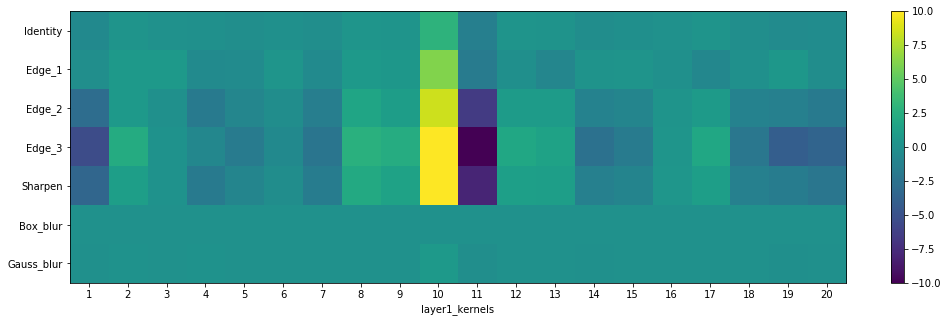

In [69]:
# now we can project on to the basis set using dot product and visualise the match
proj = np.dot(basis, layer1_kernels)

plt.figure(figsize=(20,5))
# show the transpose so that we can make labels on x-axis
plt.imshow(proj, vmax=10, vmin=-10)
plt.yticks(range(7),list(img_kernels.keys()));
plt.xticks(range(20), np.arange(1,21))
plt.xlabel('layer1_kernels')
plt.colorbar(fraction=0.015, pad=0.04);

From this it's more clear that there are no blurring kernels, apart from kernel 10, which is probably due to it's similarity with the identity kernel. This intuitively makes sense since humans also find it harder to classify blurred images. All of the kernels are edge detectors in combination with a varying amount of identity kernel. The most prominent Edge_3 type kernel is 10 whereas 11 does the opposite. To find out the similarities in these kernels we can plot the results when passing test images.

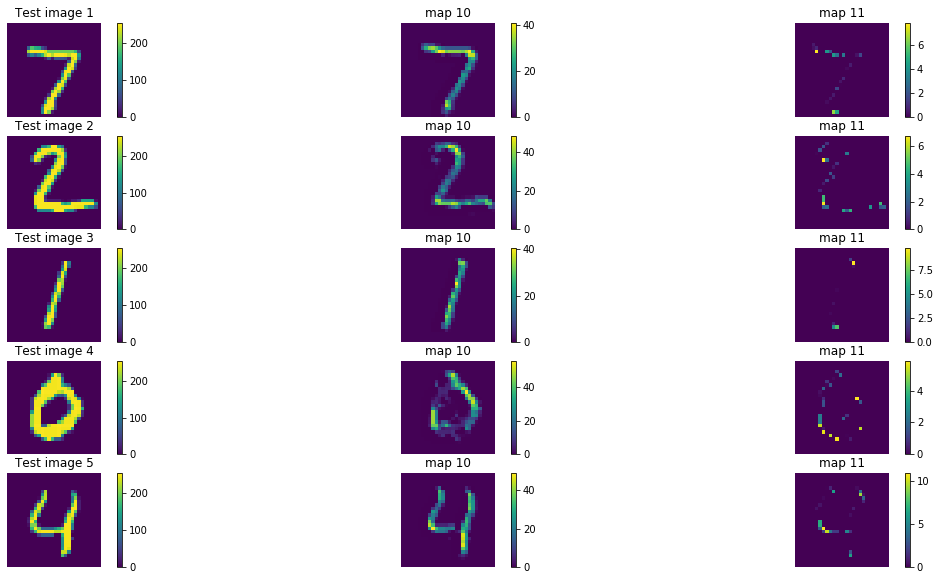

In [54]:
# Copy and pasted our feature map subplot a few cells above

fig, ax = plt.subplots(5,3, figsize=(20,10))
for i in range(5):
    for j in enumerate([0,10,11]):
        if j[0]==0:
            img = ax[i,j[0]].imshow(x_test[i,:,:,0])
            fig.colorbar(img, ax=ax[i,j[0]])
            ax[i,j[0]].set_title('Test image {}'.format(i+1))
            ax[i,j[0]].axis('off')
        else:
            img = ax[i,j[0]].imshow(predict[i,:,:,j[1]-1])
            fig.colorbar(img, ax=ax[i,j[0]])
            ax[i,j[0]].set_title('map {}'.format(j[1]))
            ax[i,j[0]].axis('off')


Looking closely, there are some similarities between kernels 13 and 17 and kernels 2 and 9. Plotting those in the figure below will uncover the process of this type of kernel:

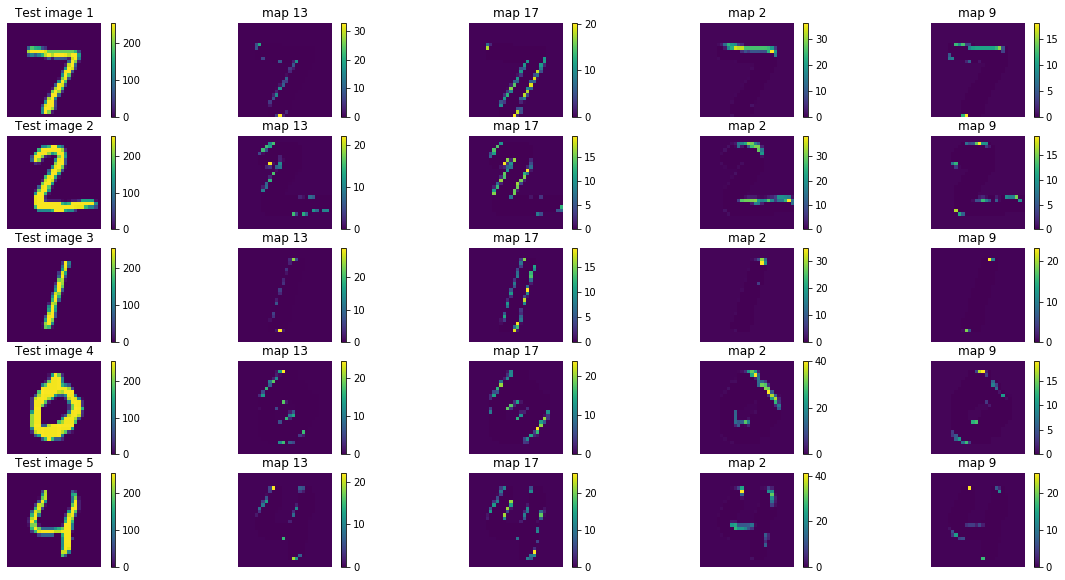

In [58]:
fig, ax = plt.subplots(5,5, figsize=(20,10))
for i in range(5):
    for j in enumerate([0,13,17,2,9]):
        if j[0]==0:
            img = ax[i,j[0]].imshow(x_test[i,:,:,0])
            fig.colorbar(img, ax=ax[i,j[0]])
            ax[i,j[0]].set_title('Test image {}'.format(i+1))
            ax[i,j[0]].axis('off')
        else:
            img = ax[i,j[0]].imshow(predict[i,:,:,j[1]-1])
            fig.colorbar(img, ax=ax[i,j[0]])
            ax[i,j[0]].set_title('map {}'.format(j[1]))
            ax[i,j[0]].axis('off')

Let's see what the basis filters actually do to the images, we can initialise a model to ouput the result of the first layer like we did before but replace the first 7 learned kernels with the basis kernels:

In [28]:
# use keras.Model to take the already defined specs from parts of our CNN we trained
# and make a new model which only passes inputs through the first layer

layer1_weights = model.layers[0].get_weights()

# Set the first 7 kernels to be the img_kernels defined above
for i in enumerate(keys):
    layer1_weights[0][:,:,0,i[0]] = img_kernels[i[1]]

model.layers[0].set_weights(layer1_weights)

output_img_kernels = k.Model(inputs=model.inputs, outputs=model.layers[0].output, name='output_img_kernels')
output_img_kernels.summary()

Model: "output_img_kernels"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1_input (InputLayer)  (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 20)        200       
Total params: 200
Trainable params: 200
Non-trainable params: 0
_________________________________________________________________


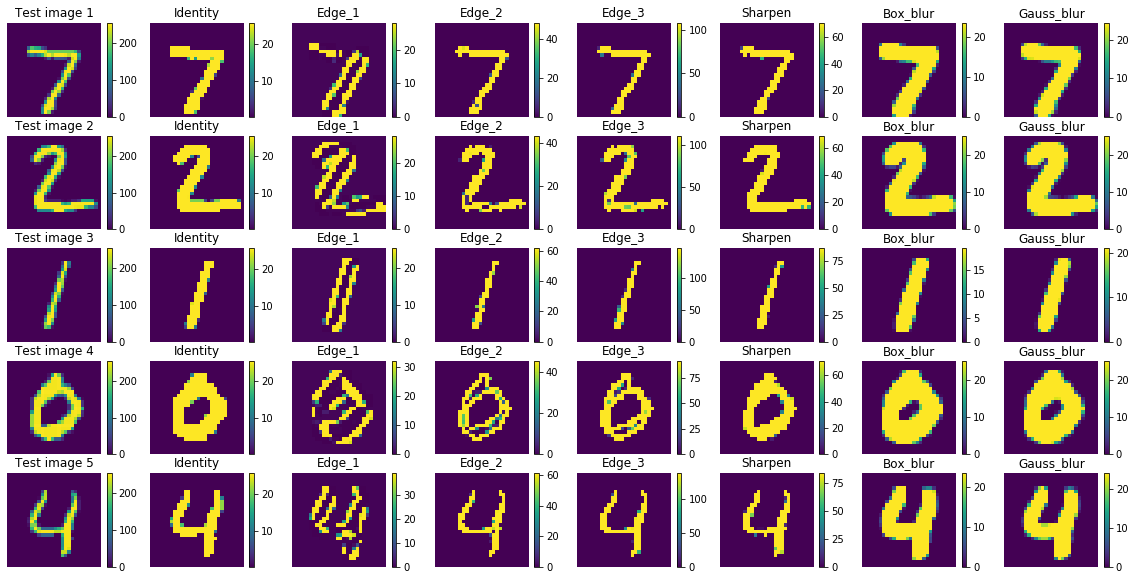

In [29]:
# get the output of the first layer for the first 5 test images
predict = output_img_kernels.predict(x_test[0:5])

# Make a subplot to show results
fig, ax = plt.subplots(5,8, figsize=(20,10))

for i in range(5):
    for j in range(8):
        if j==0:
            img = ax[i,j].imshow(x_test[i,:,:,0])
            fig.colorbar(img, ax=ax[i,j])
            ax[i,j].set_title('Test image {}'.format(i+1))
            ax[i,j].axis('off')
        else:
            img = ax[i,j].imshow(predict[i,:,:,j-1],
                                vmax=0.1*predict[i,:,:,j-1].max())
            fig.colorbar(img, ax=ax[i,j])
            ax[i,j].set_title(list(img_kernels.keys())[j-1])
            ax[i,j].axis('off')


We can see that our learned kernel 10 is indeed very similar to a Edge_3 type kernel. 

Using `model.get_weights()` and `model.set_weights()` is the trick to finding out the motivations behind CNN classifications. 

The initialisation of kernels when building our model can help encourage the training to find more sensible mappings and could also speed up the training. For example if we know the image is a classification task then instead of starting with randomly generate kernels we could use the Edge_3 kernel. Likewise if we knew the output was to be a sharpened or blurred image then we could use these kernels at the beginning of the training. To do this we use the `kernel_initialiser` argument when making the `Conv2D` layer. For example code see: https://keras.io/api/layers/convolution_layers/convolution2d/

There is also a function for adding a regularisation term to the kernels which prevents one element of a kernel from becoming too large. This can also be applied to weights in a multilayer perceptron (fully connected arificial neural network) too. https://keras.io/api/layers/regularizers/

In [49]:
# Note, this is to load in the results again.
model = k.models.load_model('example_CNN', custom_objects={'softmax_v2': tf.nn.softmax})